<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/pyvital.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to analyze biosignal data using Pyvital library
In this example, we will learn how to analyze biosinal data using `pyvital` library. For more information about `pyvital` library, see: https://github.com/vitaldb/pyvital

## Download 'pyvital' library
Intall `pyvital` library using `pip`.

In [1]:
!pip install pyvital

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


import `vitaldb` library to read vital file.

In [2]:
import vitaldb

## Read sample data
Read sample biosignal data using `vitaldb` python library.

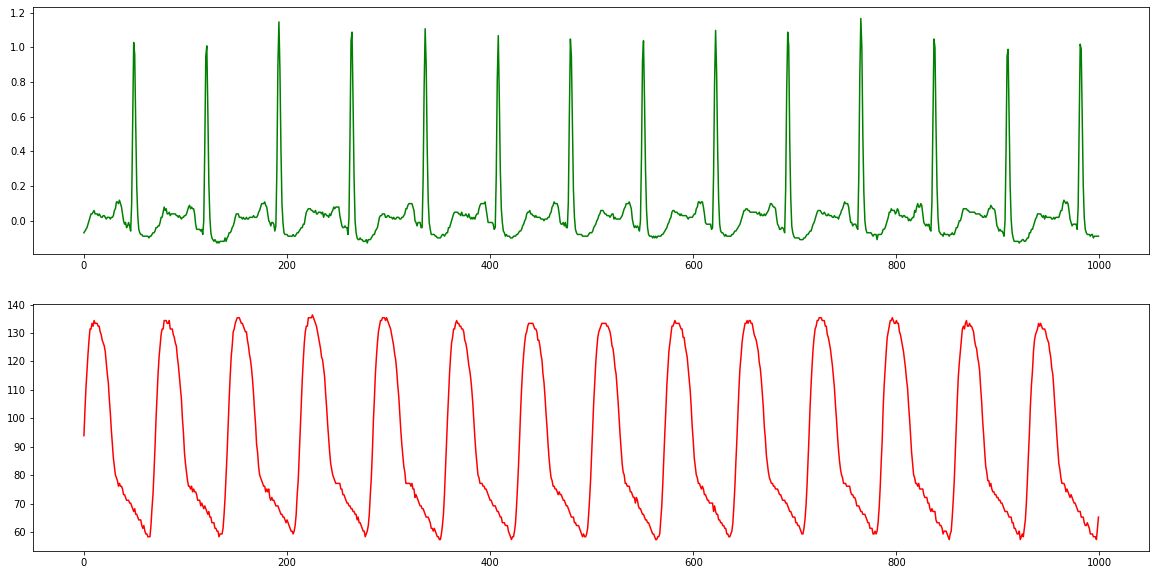

In [18]:
import vitaldb
vals = vitaldb.vital_recs('https://vitaldb.net/samples/00001.vital', ['ECG_II','ART'], 1/100)

import matplotlib.pyplot as plt
ecg = vals[110000:111000, 0]
art = vals[110000:111000, 1]
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(ecg, color='g')
plt.subplot(212)
plt.plot(art, color='r')
plt.show()

## Detect R peak from ECG
`pyvital.arr.detect_qrs(data, srate)` finds R peaks from  ECG and returns the indexes of the peaks.
Reference. Pan and Tompkins, A Real-Time QRS Detection Algorithm. IEEE Transactions on Biomedical Engineering BME-32.3 (1985)

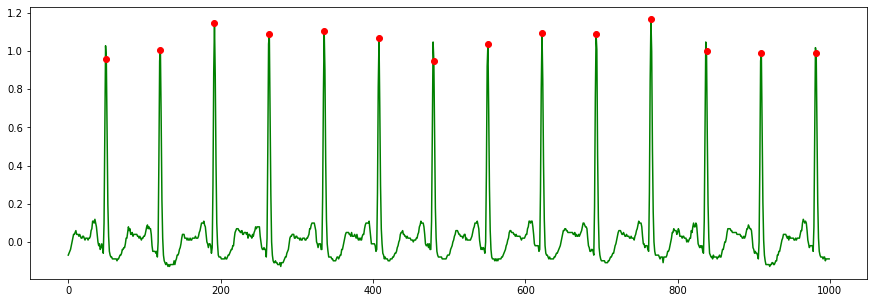

In [19]:
import pyvital.arr
ecg = vals[110000:111000, 0]
ecg = pyvital.arr.exclude_undefined(ecg)
peaks = pyvital.arr.detect_qrs(ecg, 100) # find qrs and return the indexes

plt.figure(figsize=(15,5))
plt.plot(ecg, color='g')
plt.plot(peaks, [ecg[i] for i in peaks], 'ro')
plt.show()

## Detect peaks from arterial pressure waveform
`pyvital.arr.detect_peaks(data, srate)` obtains peaks and valleys from blood pressure or pleth waveform. The number of valleys is always one less than the number of peaks.

[[63, 133, 206, 277, 350, 421, 491, 563, 635, 707, 777, 852, 922], [10, 79, 151, 225, 294, 367, 438, 510, 582, 653, 724, 796, 869, 940]]


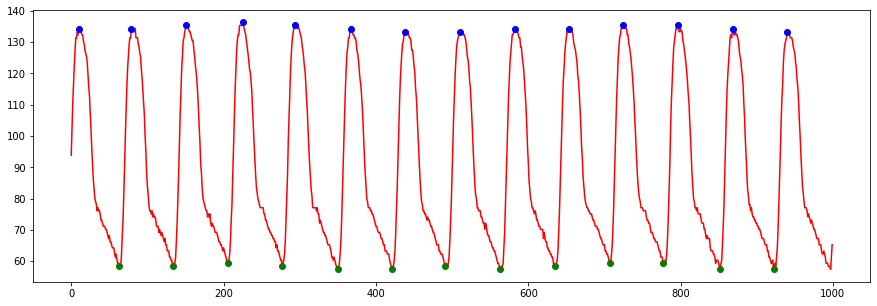

In [20]:
art = pyvital.arr.exclude_undefined(art)
peaks = pyvital.arr.detect_peaks(art, 100) # Obtain maximum and minimum values from blood pressure or pleth waveform
print(peaks)

plt.figure(figsize=(15,5))
plt.plot(art, color='r')
plt.plot(peaks[0], [art[i] for i in peaks[0]], 'go') # minimum values from BP or pleth waveform
plt.plot(peaks[1], [art[i] for i in peaks[1]], 'bo') # maximum values from BP or pleth waveform
plt.show()

## How to apply filter
You can calculate the Pulse Pressure Variation (PPV) using the arterial pressure waveform. To do this, we need to use `pyvital.filters.abp_ppv` used by Vital Recorder.

In [21]:
import pyvital.filters.abp_ppv as f
f.cfg

{'desc': 'Calculate pulse pressure variation using modified version of the method in the reference',
 'group': 'ABP',
 'inputs': [{'name': 'ART', 'type': 'wav'}],
 'interval': 30,
 'name': 'ART - Pulse Pressure Variation',
 'outputs': [{'max': 30, 'min': 0, 'name': 'PPV', 'type': 'num', 'unit': '%'},
  {'max': 30, 'min': 0, 'name': 'SPV', 'type': 'num', 'unit': '%'},
  {'max': 30, 'min': 0, 'name': 'ART_RR', 'type': 'num', 'unit': '/min'}],
 'overlap': 20,
 'reference': 'Aboy et al, An Enhanced Automatic Algorithm for Estimation of Respiratory Variations in Arterial Pulse Pressure During Regions of Abrupt Hemodynamic Changes. IEEE TRANSACTIONS ON BIOMEDICAL ENGINEERING, VOL. 56, NO. 10, OCTOBER 2009'}

Let's apply a PPV filter that reads arterial pressure at 100 Hz.

In [22]:
art = vals[300000:306000, 1]
res = f.run({'ART':{'srate':100, 'vals':art}}, {}, f.cfg)
res[0]

ValueError: ignored